In [1]:
from Import.FEMReader import *
from Core.GlobalK     import *
from Export.ExportVTK import *

In [2]:
inp_path = r'C:\Users\Михаил\Desktop\Prog\Python\PyFEM\Data\Column_v1.inp'

setup = read_setup(inp_path)

In [3]:
nodes = setup['*NODE']/1e3
elems = setup['*ELEMENT, TYPE=C3D4, ELSET=P2;Default PSHELL_Volume_1']

fix_set  = setup['*NSET, NSET=Basement_Set']
load_set = setup['*NSET, NSET=Top_Set']

n_dofs = nodes.shape[0]*3

matprops = [(210e9, 0.3, 7950) for i in range(len(elems))]

In [4]:
# Matrix assembly
# Stiffness
K = assemble_K(nodes, elems, matprops, callback = local_K_tetra)
# Mass
M = assemble_K(nodes, elems, matprops, callback = local_M_tetra_lumped)

In [5]:
dt      = 3e-6 
n_steps = 15000

fixed_dofs = [ ]
for n in fix_set:
    fixed_dofs += [3*n, 3*n+1, 3*n+2]

load_dofs = [ ]
for n in load_set:
    load_dofs += [3*n]

# Linear Ramp load
load = np.ones(n_steps) *1e4

In [6]:
u_hist = solve_dynamic(K, M.diagonal(), fixed_dofs, load_dofs, load, dt, n_steps)[::500]

In [7]:
for ui, u_ in enumerate(u_hist):
    ux, uy, uz = u_[0::3], u_[1::3], u_[2::3]
    set_indicator = np.zeros(nodes.shape[0])
    set_indicator[fix_set] = 1
    set_indicator[load_set] = 2
    export_VTK(setup['*NODE'][:, 1:], setup['*ELEMENT, TYPE=C3D4, ELSET=P2;Default PSHELL_Volume_1'], f'VTK_Output\\Dyna_{ui:04d}.vtk', node_scalars={
        'Displacements' : np.column_stack([ux, uy, uz]), 'Sets': set_indicator
    })

In [8]:
from matplotlib import pyplot as plt 

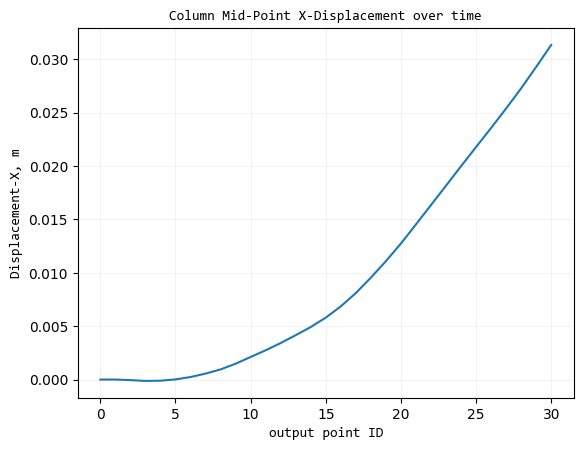

In [14]:
point_hist = [u[7295*3] for u in u_hist]
plt.plot(point_hist)
plt.xlabel('output point ID', font = 'Consolas', fontsize = 10)
plt.ylabel('Displacement-X, m', font = 'Consolas', fontsize = 10)
plt.grid(alpha = 0.15)
plt.title('Column Mid-Point X-Displacement over time', font = 'Consolas', fontsize = 10)
plt.show()